Text(0, 0.5, 'normalized flux, scaled')

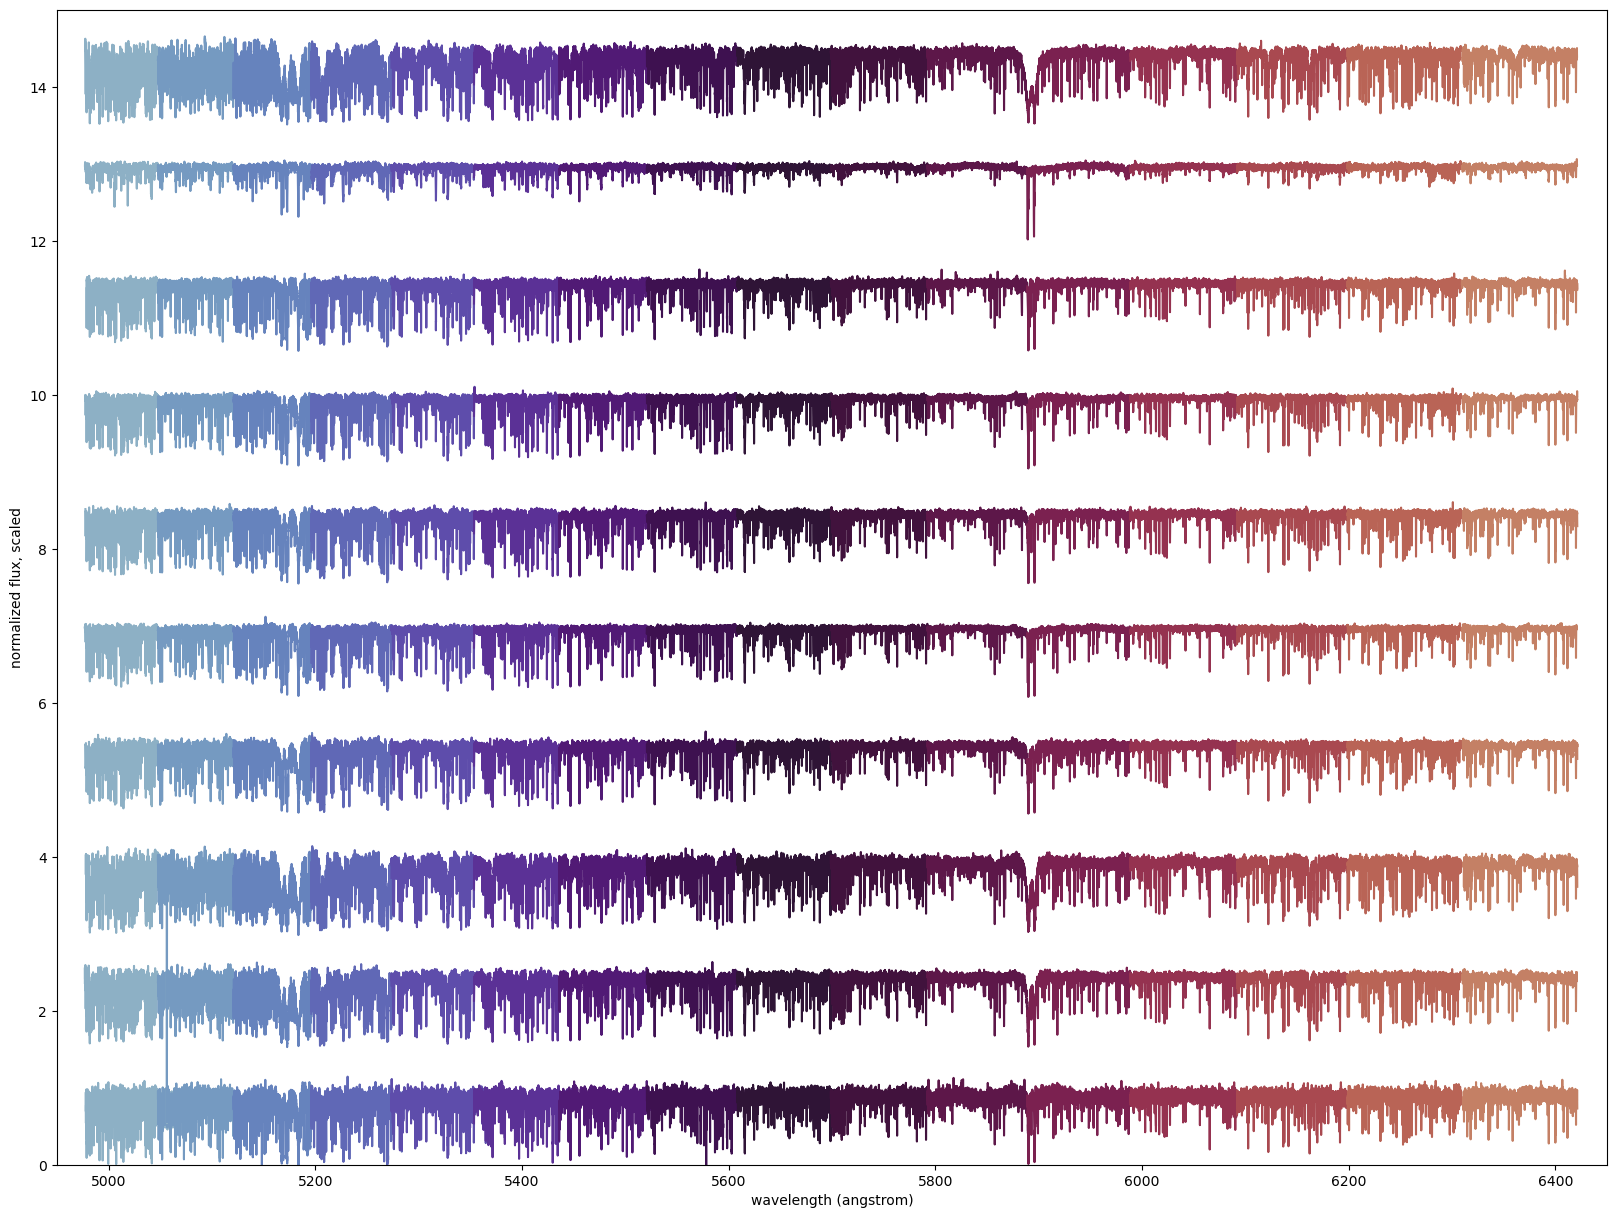

In [7]:
# plot of all the orders 
from astropy.io import fits
import glob
import matplotlib.colors
from pylab import *

shifted_path = './data/cks-spectra_shifted_resampled_r'
test_filenames = glob.glob(shifted_path+'/order1/*.fits')
shifted_targets = [i.split('/')[4].replace('.fits','') for i in test_filenames][:10]
norm = matplotlib.colors.Normalize(vmin=-2, vmax=20)

figure(figsize=(20,15))
for i in range(len(shifted_targets)):
    target = shifted_targets[i]
    for order_n in range(1,17):
        order_filename = '{}/order{}/{}.fits'.format(shifted_path,order_n,target)
        order_data = fits.open(order_filename)[1].data
        plot(order_data.w, order_data.s+i*1.5, c=cm.twilight(norm(order_n)))
ylim(0,15);xlim(4950,6450)
xlabel('wavelength (angstrom)');ylabel('normalized flux, scaled')


Text(0, 0.5, 'normalized flux, scaled')

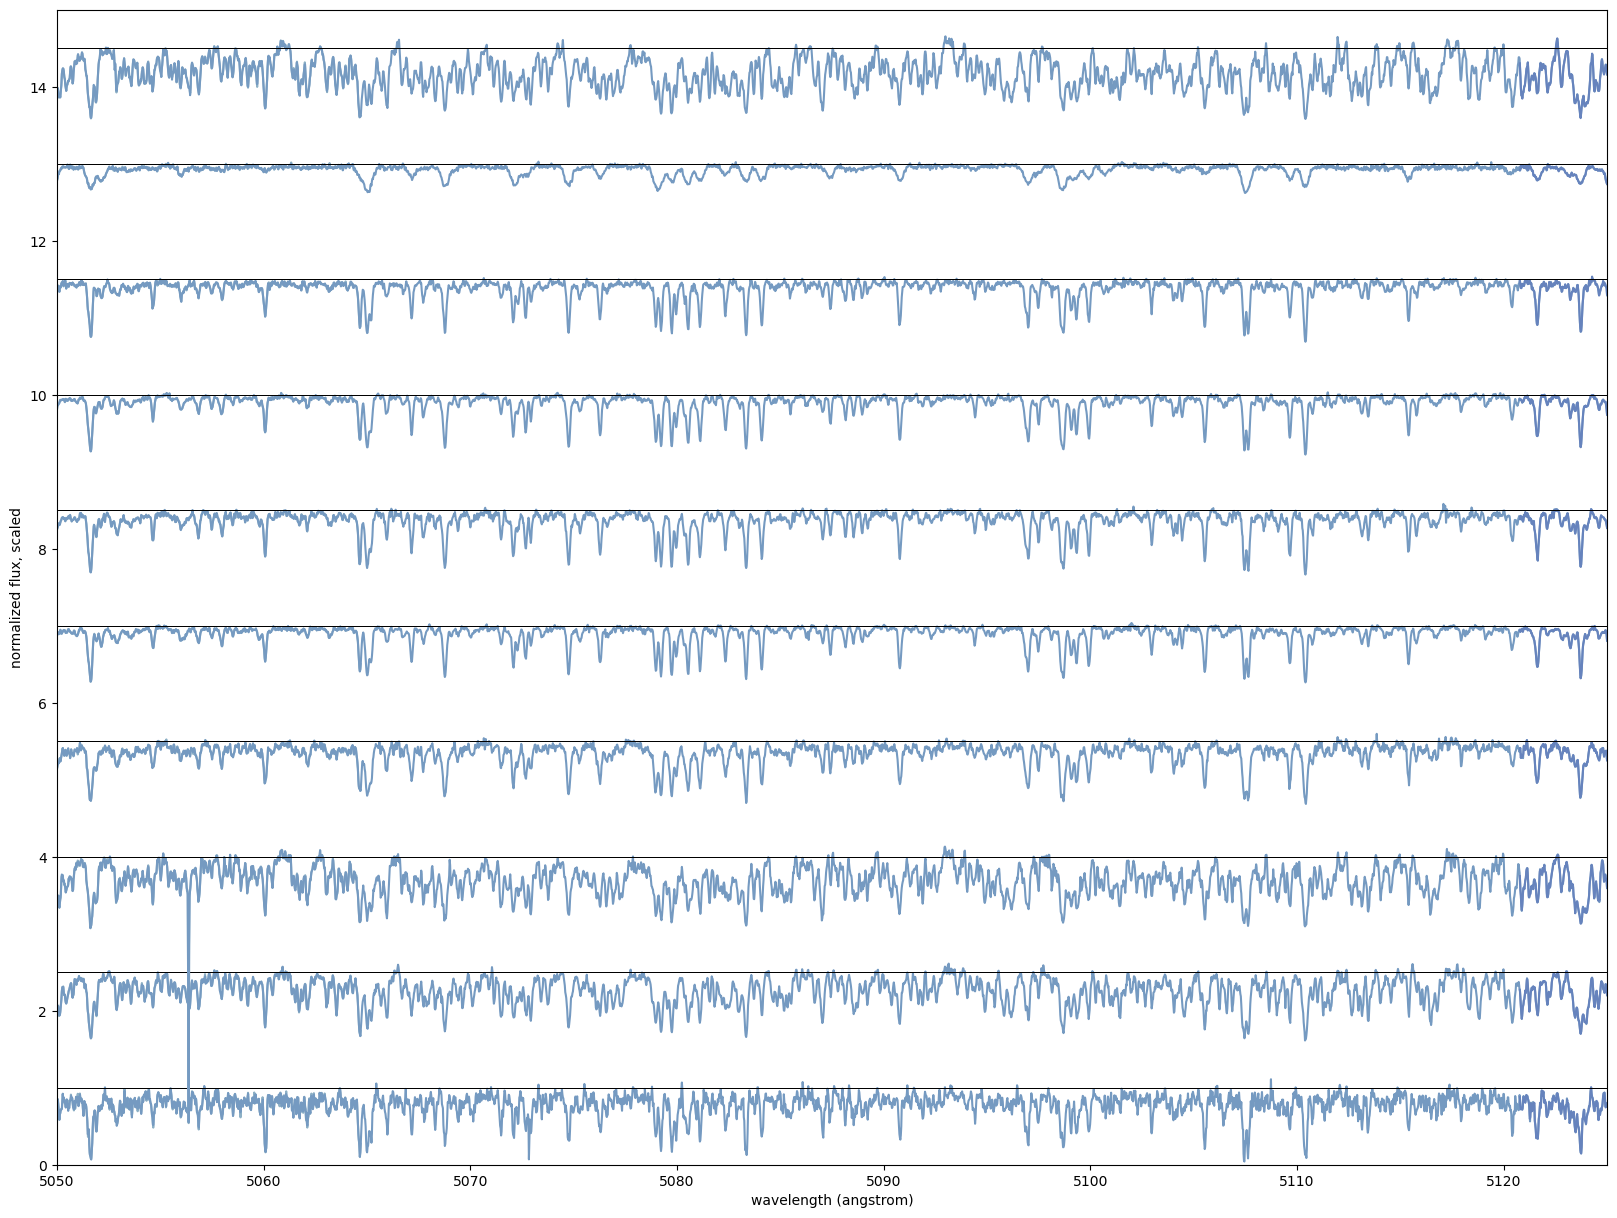

In [9]:
# plot of just order 2
figure(figsize=(20,15))
for i in range(len(shifted_targets)):
    target = shifted_targets[i]
    for order_n in range(1,17):
        order_filename = '{}/order{}/{}.fits'.format(shifted_path,order_n,target)
        order_data = fits.open(order_filename)[1].data
        axhline(i*1.5+1, lw=0.4, color='k')
        plot(order_data.w, order_data.s+i*1.5, c=cm.twilight(norm(order_n)))
ylim(0,15);xlim(5050,5125)
xlabel('wavelength (angstrom)');ylabel('normalized flux, scaled')

Text(0, 0.5, 'wavelet-filtered flux + offset')

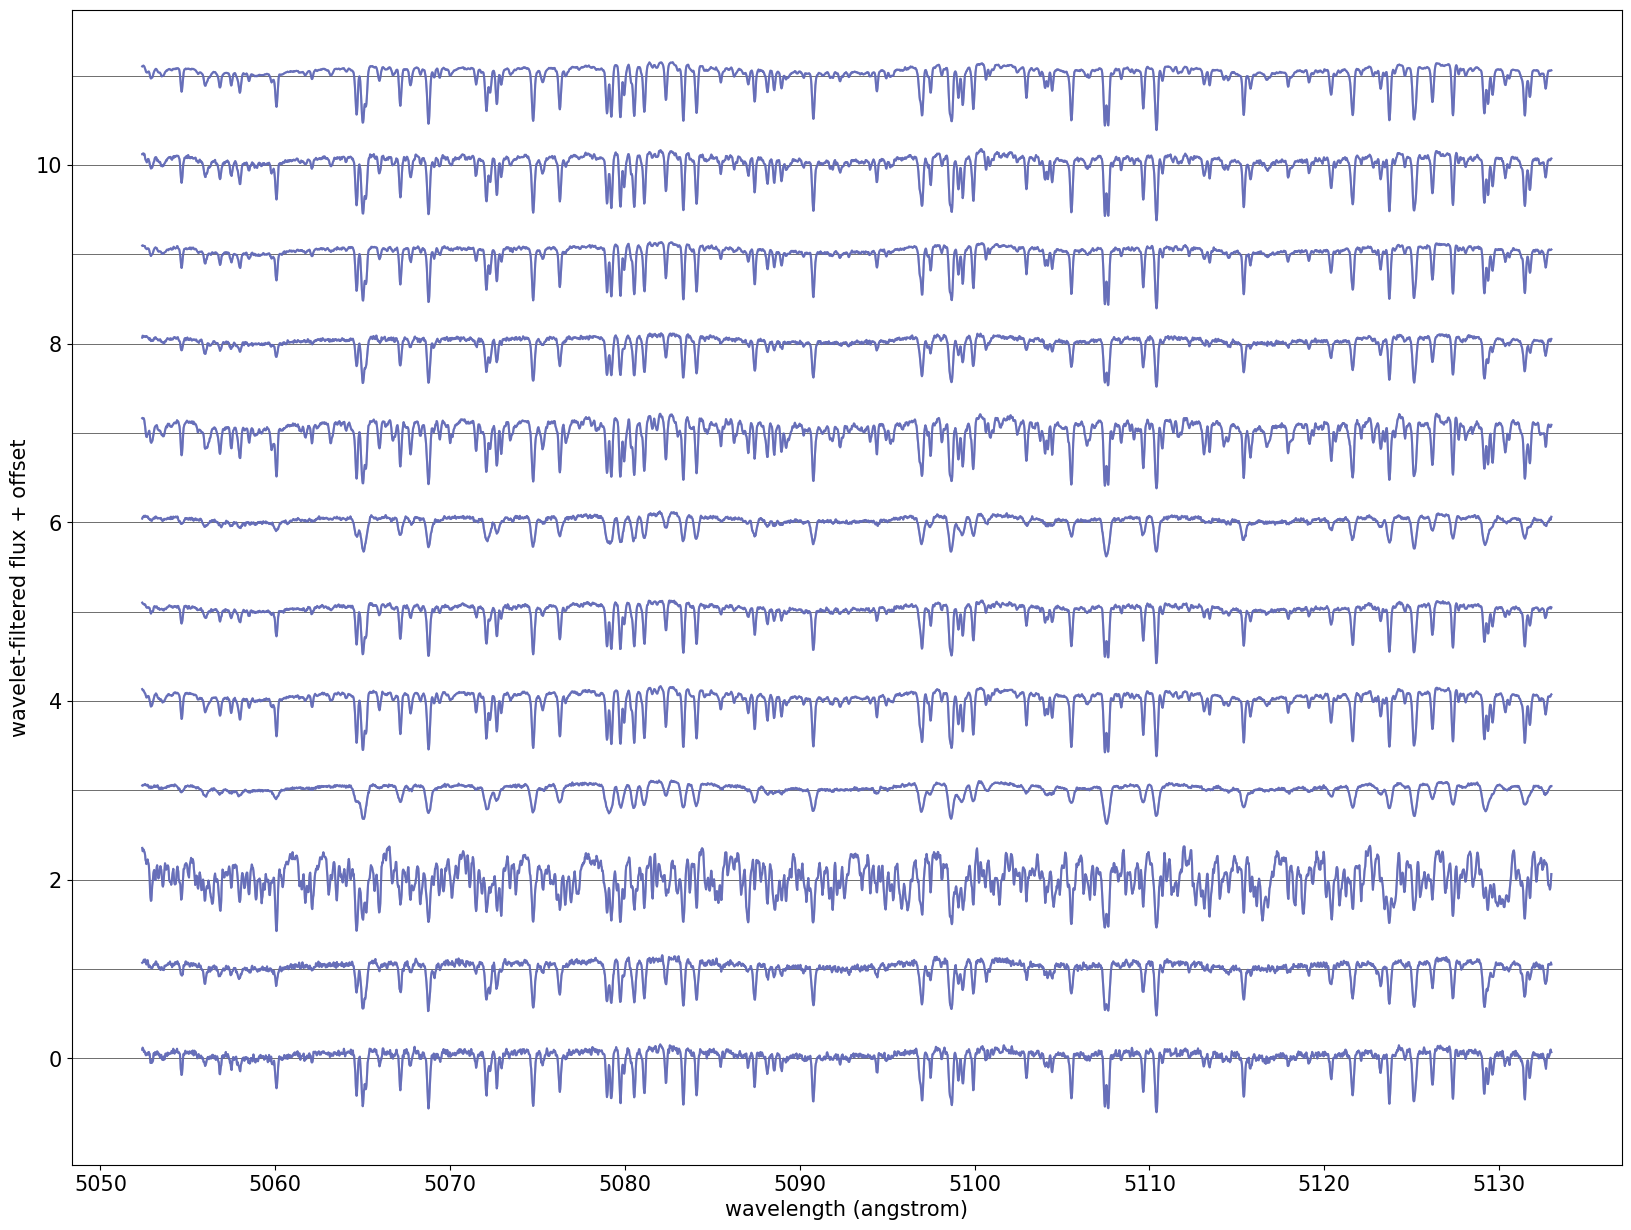

In [11]:
# order 2 spectra of the training set
import pandas as pd
training_flux = pd.read_csv('./data/cannon_training_data/training_flux_dwt.csv').query('order_number==2')
reference_w = fits.open('./data/cannon_training_data/cannon_reference_w.fits')[0].data
w1 = reference_w[1]
i=0

figure(figsize=(20,15))
rcParams['font.size']=15
for target in training_flux.columns[1:13]:
    axhline(i, lw=0.4, color='k')
    plot(w1, training_flux[target]+i, c=cm.twilight(norm(4)), alpha=0.5)
    plot(w1, training_flux[target]+i, c=cm.twilight(norm(4)), alpha=0.9)
    i+=1
xlabel('wavelength (angstrom)');ylabel('wavelet-filtered flux + offset')

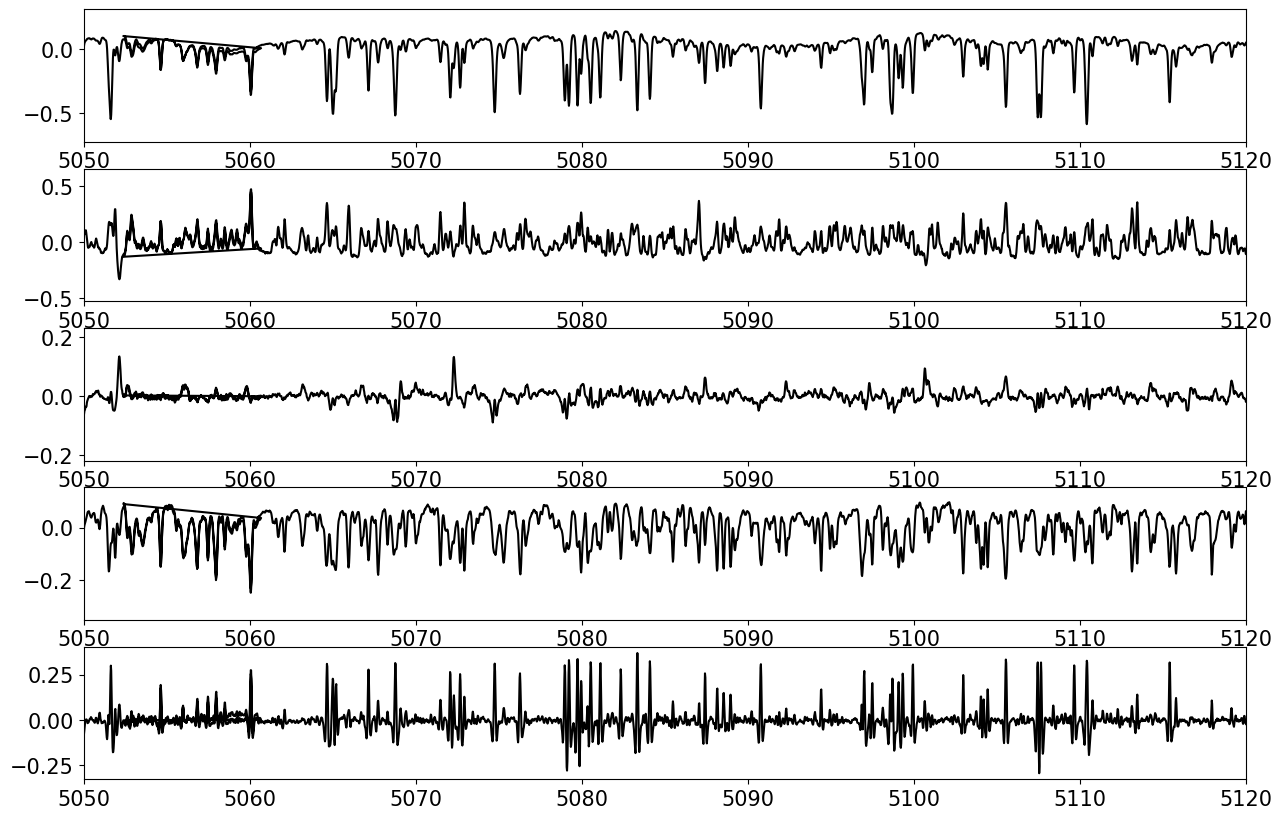

In [16]:
# let's see what the cannon model coefficients look like at these wavelengths,
# just for fun

import thecannon as tc
model = tc.CannonModel.read('./data/cannon_models/rchip_orders_11-12_omitted_dwt/rchip_orders_11-12_omitted_dwt.model')
order_numbers = [i for i in range(1,17) if i not in (11,12)]
wav = reference_w[[i-1 for i in order_numbers]].flatten()

figure(figsize=(15,10))
i=1
for theta in model.theta.T[:5]:
    subplot(5,1,i)
    plot(wav, theta, 'k-')
    xlim(5050,5120)
    i+=1

Text(0, 0.5, 'normalized flux (+ offset)')

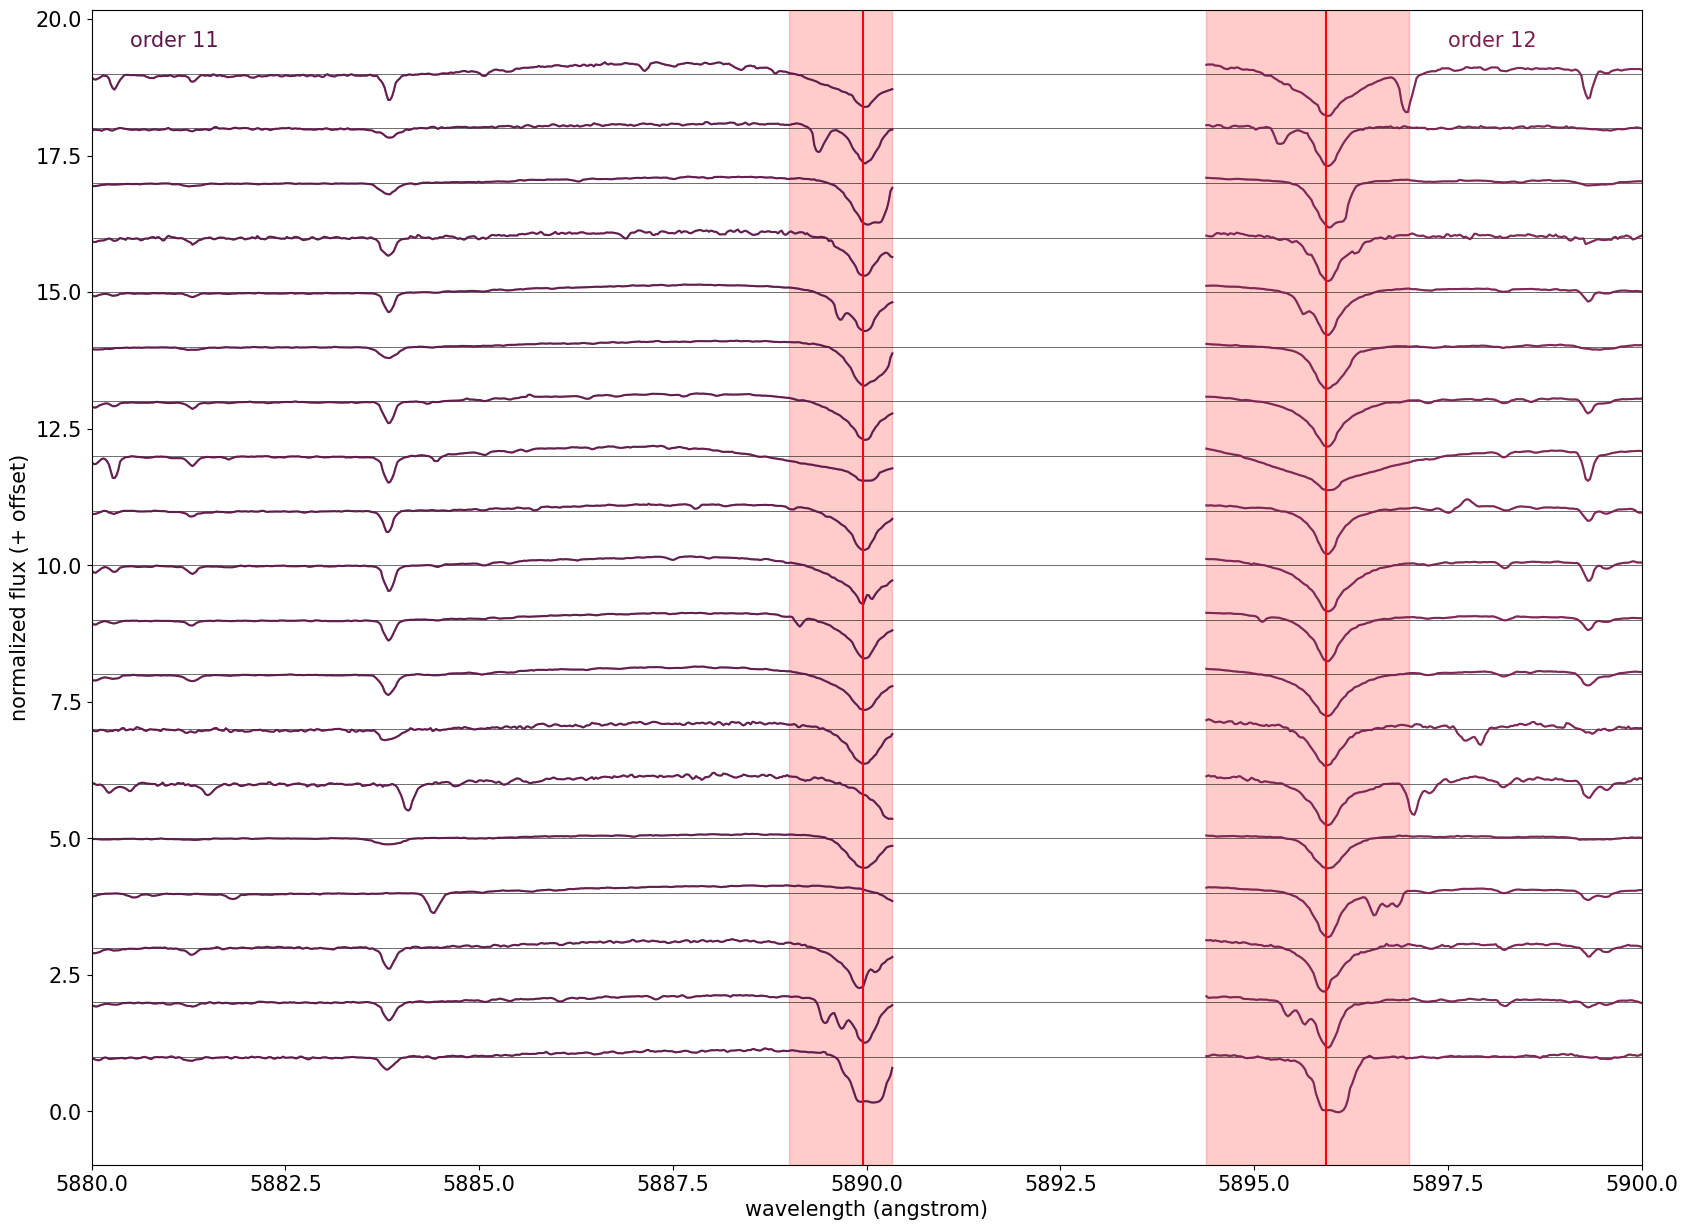

In [16]:
# plot of the adopted calcium doublet mask

order_path = './data/cks-spectra_shifted_resampled_r/'
order11 = pd.read_csv('./data/cks-spectra_dataframes/training_flux_order11.csv')
w11 = reference_w[10]

order12 = pd.read_csv('./data/cks-spectra_dataframes/training_flux_order12.csv')
w12 = reference_w[11]

i=0
figure(figsize=(20,15))
for target in order11.columns[9:28]:
    axhline(i+1, lw=0.4, color='k')
    
    plot(w11, order11[target]+i, c=cm.twilight(norm(11)), alpha=0.3)
    plot(w12, order12[target]+i, c=cm.twilight(norm(12)), alpha=0.3)
    
    plot(w11, order11[target]+i, c=cm.twilight(norm(11)), alpha=0.95)
    plot(w12, order12[target]+i, c=cm.twilight(norm(12)), alpha=0.95)
    i+=1
xlim(5880,5900)
text(5880.5,19.5,'order 11', c=cm.twilight(norm(11)))
text(5897.5,19.5,'order 12', c=cm.twilight(norm(12)))

# plot Ca doublet features
axvline(5889.950, color='r')
axvline(5895.924, color='r')

# plot adopted masks
axvspan(5889,w11[-1], color='r', alpha=0.2)
axvspan(w12[0],5897, color='r', alpha=0.2)

xlabel('wavelength (angstrom)');ylabel('normalized flux (+ offset)')

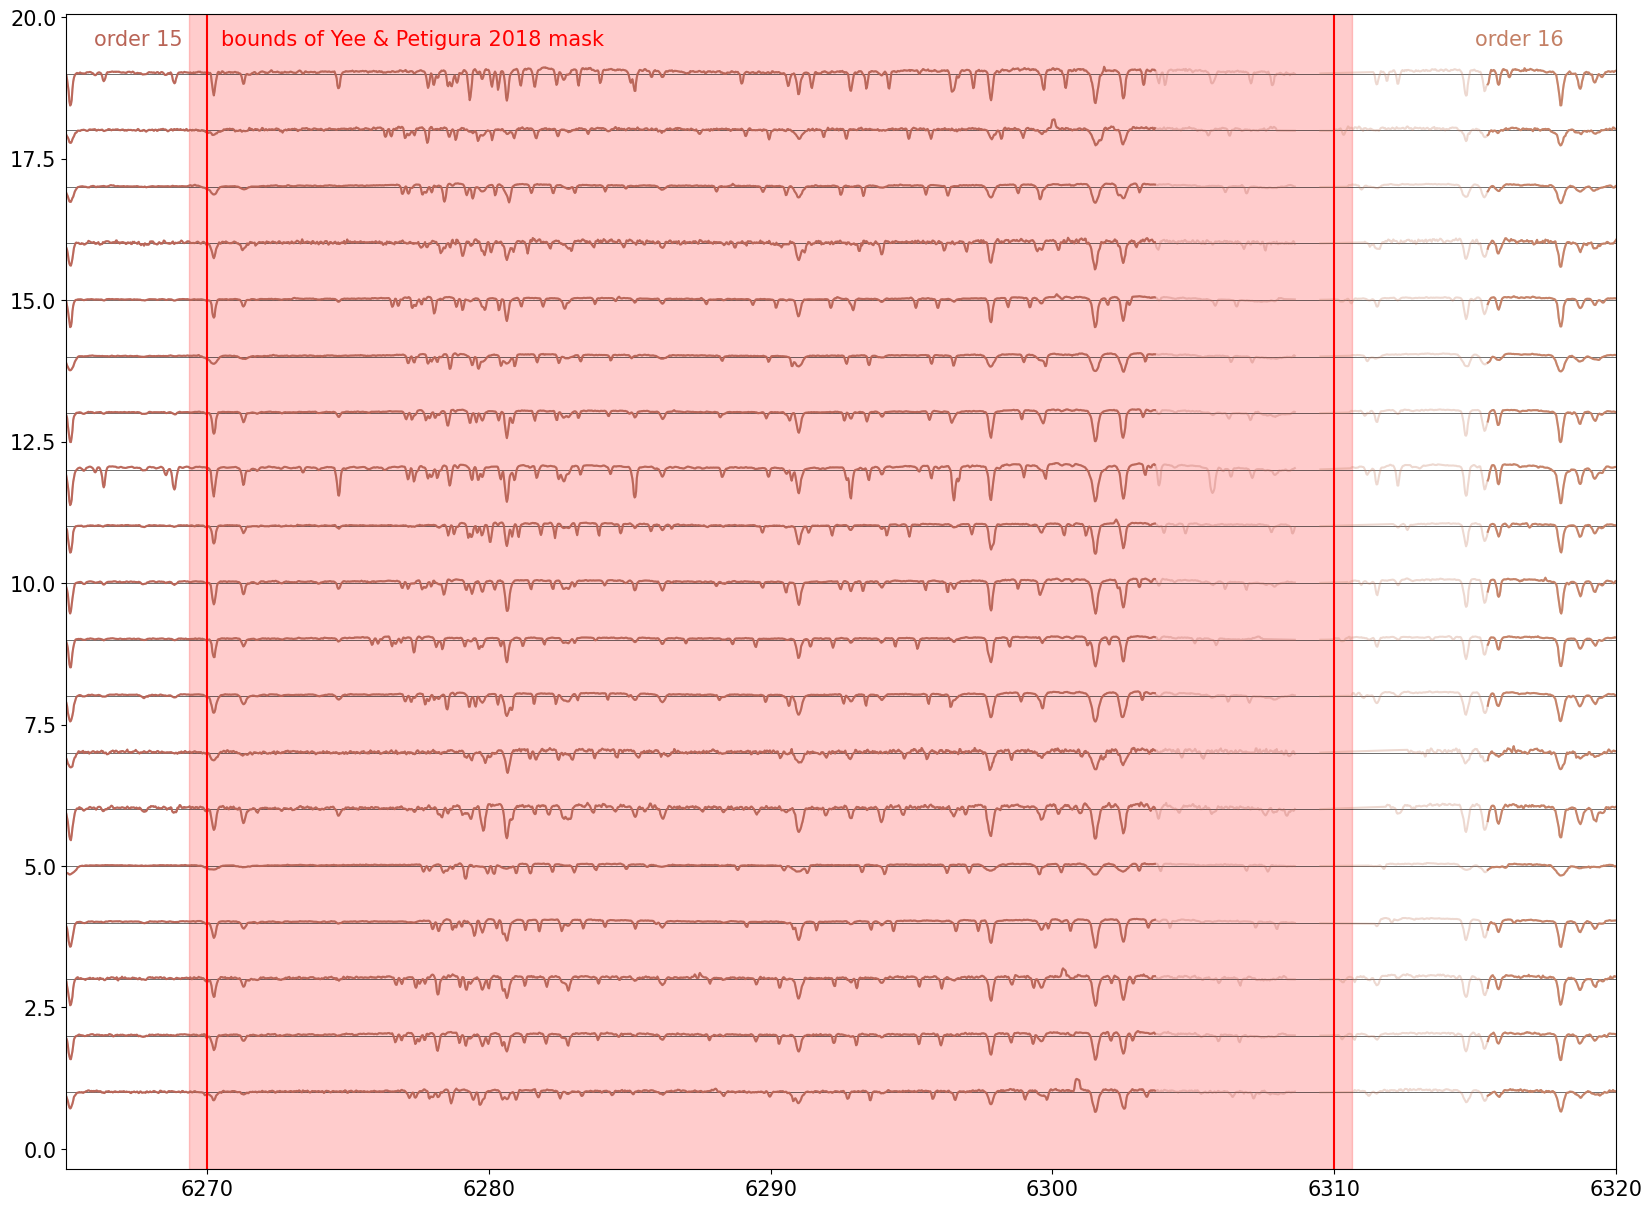

In [65]:
# plot of adopted telluric mask

order15 = pd.read_csv('./data/cks-spectra_dataframes/training_flux_order15.csv')
w15 = fits.open(order_path + 'order15/cks-k00001_rj122.742.fits')[1].data['w']

order126= pd.read_csv('./data/cks-spectra_dataframes/training_flux_order16.csv')
w16 = fits.open(order_path + 'order16/cks-k00001_rj122.742.fits')[1].data['w']

i=0
figure(figsize=(20,15))
for target in order11.columns[9:28]:
    axhline(i+1, lw=0.4, color='k')
    
    plot(w15[:-1], order15[target]+i, c=cm.twilight(norm(15)), alpha=0.3)
    plot(w16[:-1], order16[target]+i, c=cm.twilight(norm(16)), alpha=0.3)
    
    plot(w15[:-1][200:-200], order15[target][200:-200]+i, c=cm.twilight(norm(15)), alpha=0.95)
    plot(w16[:-1][200:-200], order16[target][200:-200]+i, c=cm.twilight(norm(16)), alpha=0.95)
    i+=1
xlim(6265,6320)
text(6266,19.5,'order 15', c=cm.twilight(norm(15)))
text(6315,19.5,'order 16', c=cm.twilight(norm(16)))
text(6270.5,19.5,'bounds of Yee & Petigura 2018 mask', c='r')

# plot telluric range from Yee&Petigura2018
axvline(6270, color='r')
axvline(6310, color='r')

import astropy.units as u
import astropy.constants as c
max_velocity_shift = 30*u.km/u.s
telluric_mask_min = (6270*u.angstrom*(1 - max_velocity_shift/c.c)).to(u.angstrom).value
telluric_mask_max = (6310*u.angstrom*(1 + max_velocity_shift/c.c)).to(u.angstrom).value
axvspan(telluric_mask_min, telluric_mask_max, color='r', alpha=0.2)

In [75]:
# print adopted masks:
print('telluric mask: {}-{} angstrom (padded region masked by Yee & Petigura 2018)'.format(
    np.round(telluric_mask_min,2), 
    np.round(telluric_mask_max,2)))
print('Na doublet mask: {}-{} angstrom'.format(
    5889.5,5896.5))

# notes: the sodium mask I've adopted is plotted above,
# the orders are overlapping but we clip this region (you can see from the opaque region)
# I chose a mask that looks like it encapsulated the Na doublet.
# question: does this look alright?
# question: should I be concerned about the ~10% of spectra that aren't well shifted?
# let me just update my notes for now.


telluric mask: 6269.37-6310.63 angstrom (padded region masked by Yee & Petigura 2018)
Na doublet mask: 5889.5-5896.5 angstrom
